In [115]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import sys
sys.path.insert(1, '..')

from scipy.stats import beta
from scipy.stats import lognorm
import h5py

import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
import get_wavelet_params as wp
from matplotlib import rc

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [132]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def GetBaseDir(ell, SNR):
    ell = str(ell).replace('.','p')
    SNR = str(SNR)
    
    base_dir = "/home/maria.okounkova/public_html/dCS_" + ell + "_SNR_" + SNR \
               + "/trigtime_1197495364.000000000_0.0_0.0_0/"  
    return base_dir

# Plot BW reconstructed waveforms

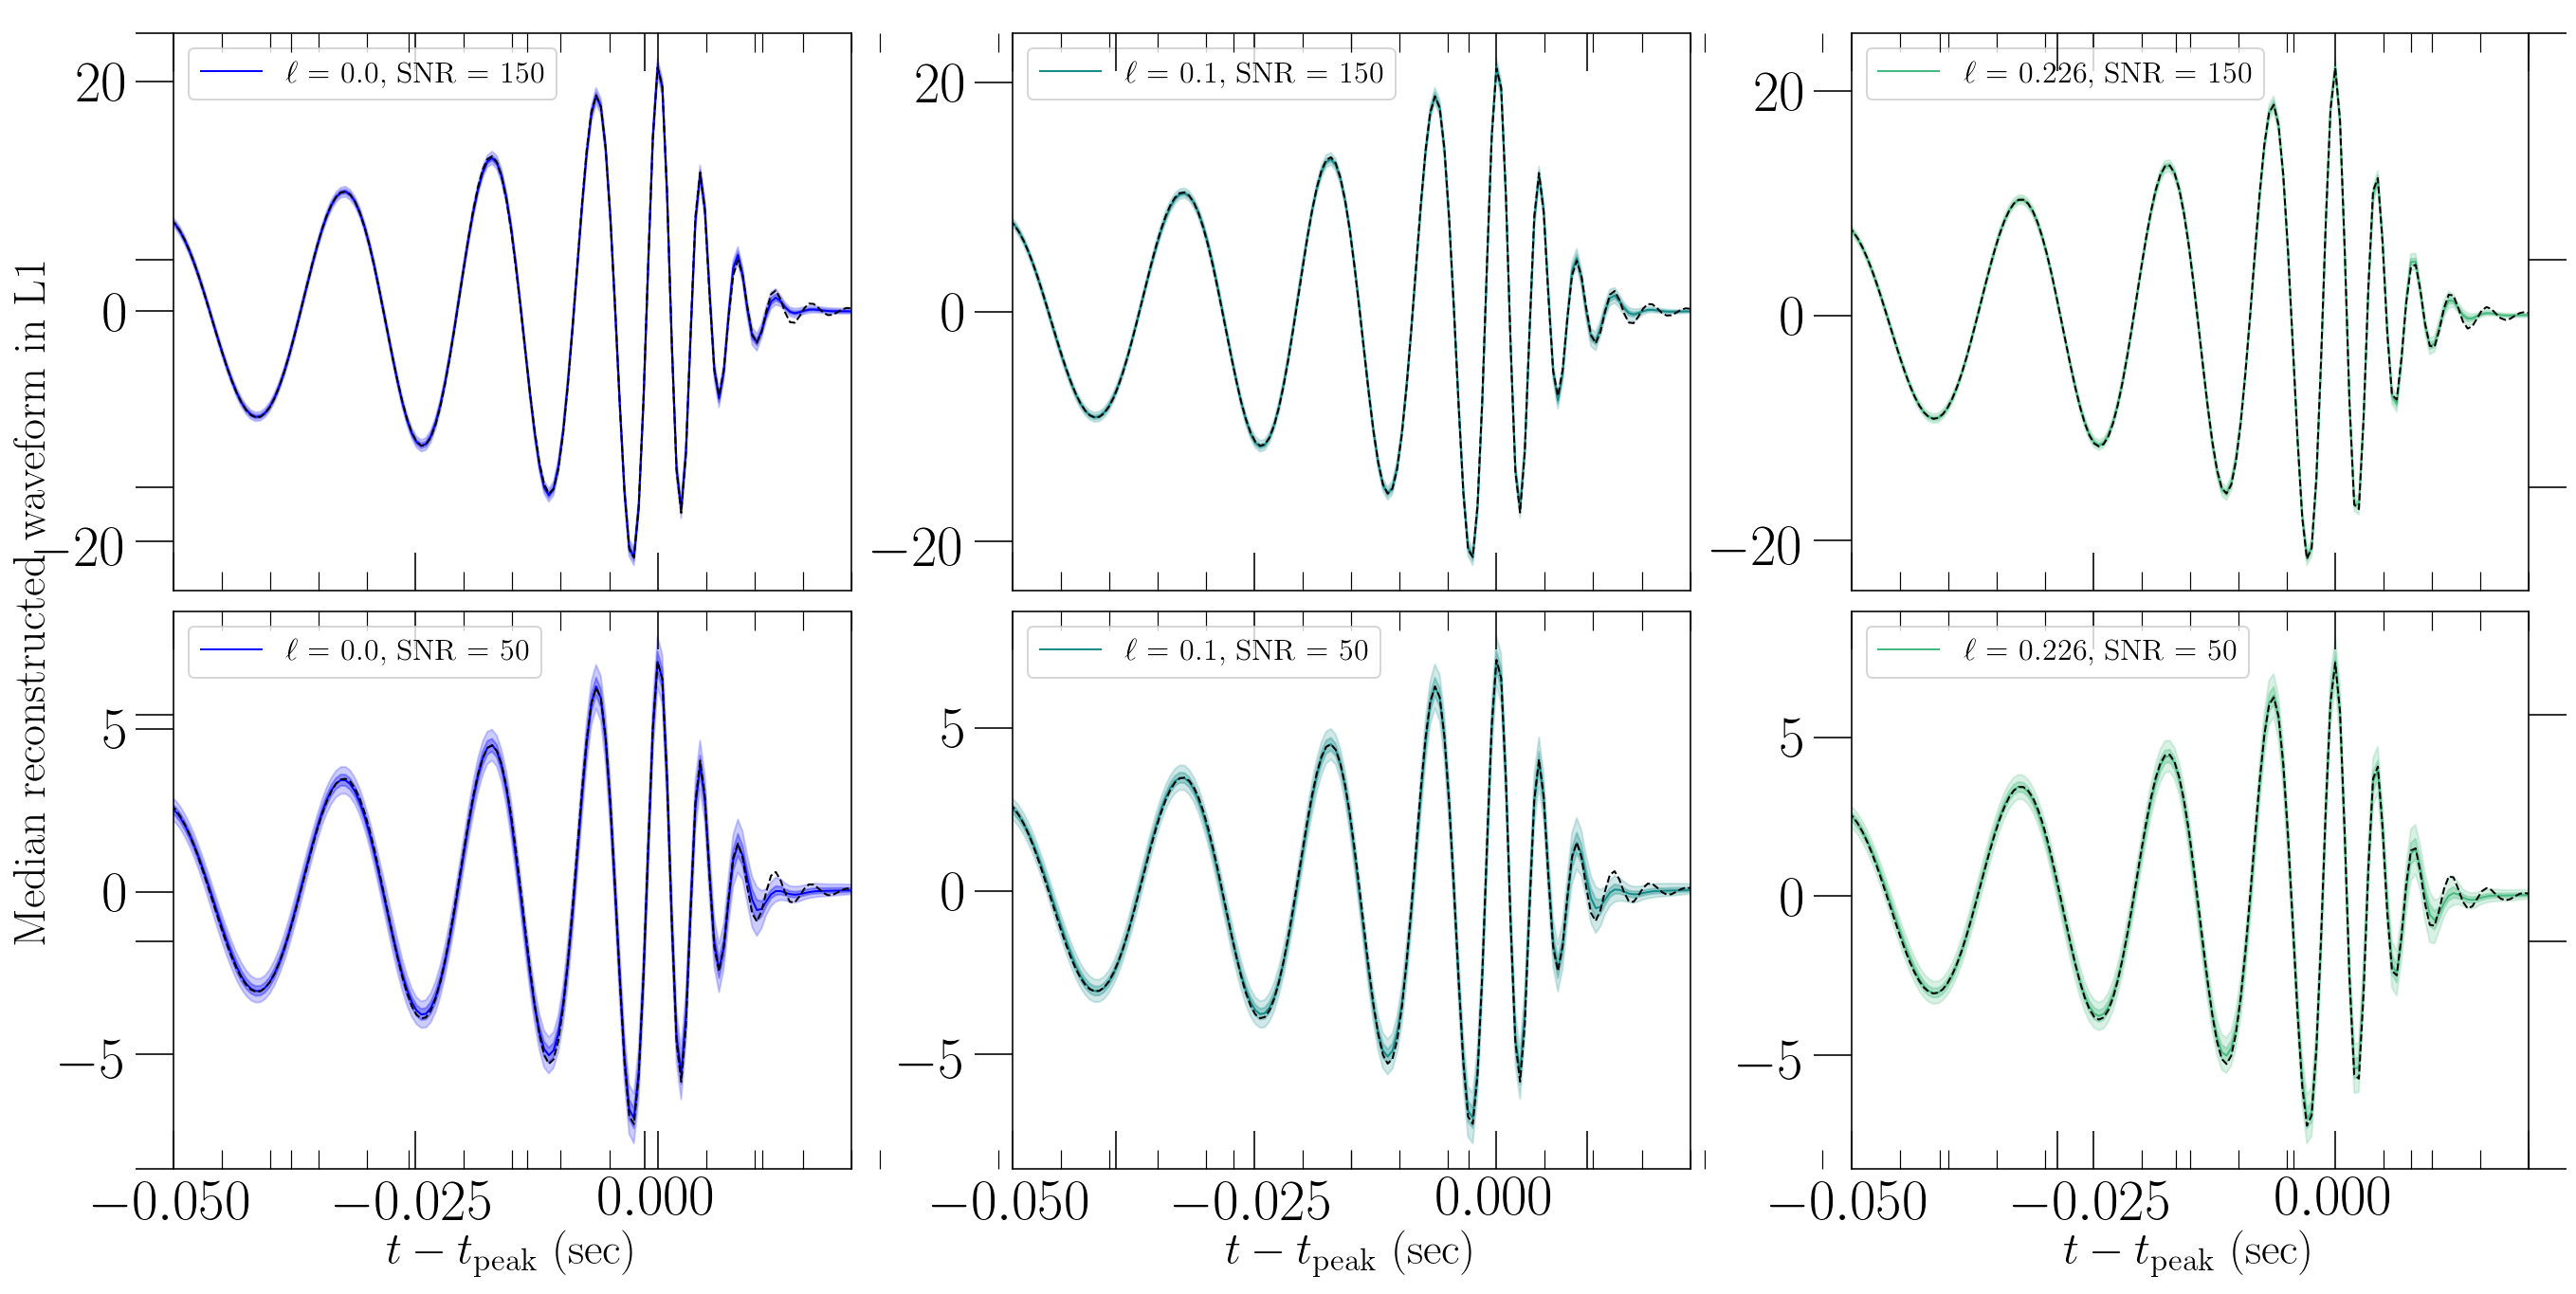

In [133]:
def GetMedianData(ell, SNR):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    base_dir = GetBaseDir(ell, SNR)
 
    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_L1.dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1, d2, d3, d4, d5


def GetInjectedData(ell, SNR):
    
    base_dir = GetBaseDir(ell, SNR)
    
    f = base_dir + 'post/whitened_data_L1.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data
    
def PlotMedianData(ax, ell, SNR, c):
    
    ## Plot the Bayeswave data
    time, d1, d2, d3, d4, d5 = GetMedianData(ell, SNR)
    label = r'$\ell$ = ' + str(ell) + ', SNR = ' + str(SNR) 
    
    ax.plot(time, d1, '-', lw = 1.0, alpha = 1.0, c=c, label=label)  
    ax.fill_between(time, d2, d3, alpha = 0.3, color=c, edgecolor=None)
    ax.fill_between(time, d4, d5, alpha = 0.2, color=c, edgecolor=None)
    
    time, data = GetInjectedData(ell, SNR)
    ax.plot(time, data, '--', color='black', lw = 1.0, alpha=1.0)
    ax.set_xlim(-0.05, 0.02)
    ax.legend(frameon=True, fontsize=16, loc='upper left')
        
fig, axarr = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

PlotMedianData(axarr[0][0], 0.0, 150, 'blue')
PlotMedianData(axarr[0][1], 0.1, 150, '#148c8a')
PlotMedianData(axarr[0][2], 0.226, 150, '#45ba7e')
PlotMedianData(axarr[1][0], 0.0, 50, 'blue')
PlotMedianData(axarr[1][1], 0.1, 50, '#148c8a')
PlotMedianData(axarr[1][2], 0.226, 50, '#45ba7e')

#plt.legend(frameon=False, fontsize=20)
plt.ylabel('Median reconstructed waveform in L1')
for i in range(3):
    axarr[1][i].set_xlabel('$t - t_\mathrm{peak}$ (sec)')

plt.tight_layout()
plt.savefig('Bayeswave.pdf')

plt.show()



# Plot evidences

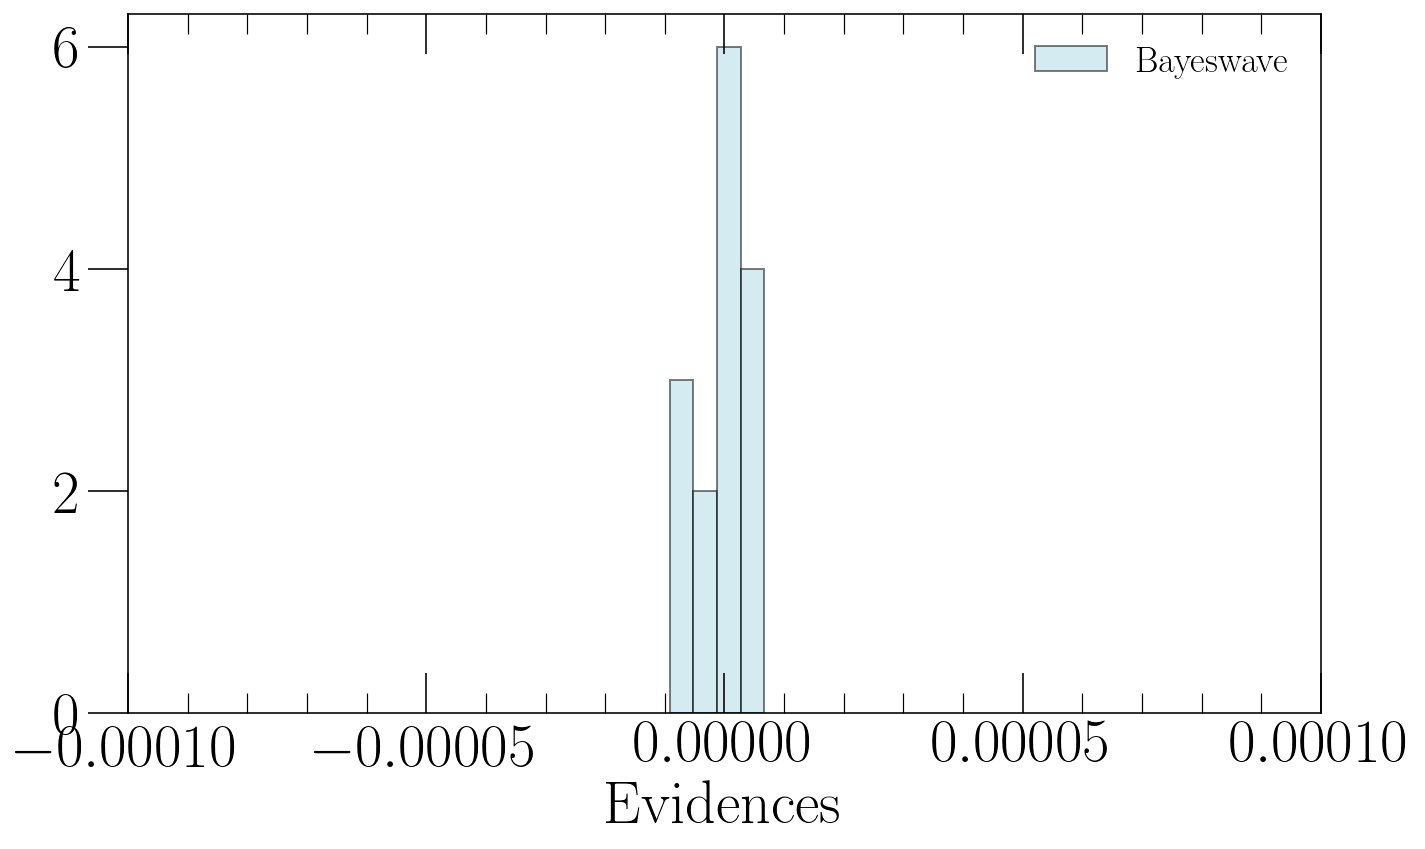

In [134]:
def GetEvidence(ell, SNR):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "signal_evidence.dat"
    ev = np.loadtxt(f, comments="#",usecols=([1]),unpack=True)[0]
    return ev
    
## Histogram the evidences for the BW case
plt.figure(figsize=(10,6))
ells = [0.0, 0.1, 0.226]
snrs = [20, 50, 80, 100, 150]
evidences = []
for SNR in [20, 50, 80, 100, 150]:
    for ell in ells:
        ev = GetEvidence(ell, SNR)
        evidences.append(ev)
n, bins, patches = plt.hist((evidences - np.average(evidences))/np.average(evidences), 4, stacked = True, facecolor='lightblue', \
                            alpha=0.5, edgecolor='black', label='Bayeswave')

plt.xlim(-1e-4, 1e-4)
plt.xlabel('Evidences', fontsize=30)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Evidences.pdf')
plt.show()

    

# Compute overlaps

## Grab frequency domain data

In [201]:
def GetPSD(ell, SNR, detector):
    
    """ Get the PSD from the same place that megaplot.py 
        gets it from. See lines 1565 - 1569 in megaplot.py
        in the ain() method """
    
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "post/signal/signal_median_PSD_" + detector + ".dat"
    freq, val = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True)
    return freq, val

def GetBWFrequencyDomainWaveform(ell, SNR, detector):
    
    """ Get the bayeswave result frequency domain waveform from the 
    same place that megaplot.py gets it from. See lines 1559 - 1563 of
    megaplot.py in the main() method """
    
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_spectrum_" \
                                                               + detector + ".dat"
    freq, re = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True)
    return freq, re + 1j*re

def GetInjectedFrequencyDomainWaveform(ell, SNR, detector):
    
    """ Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "post/gaussian_noise_model_" + detector + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im    

## Plot frequency domain data

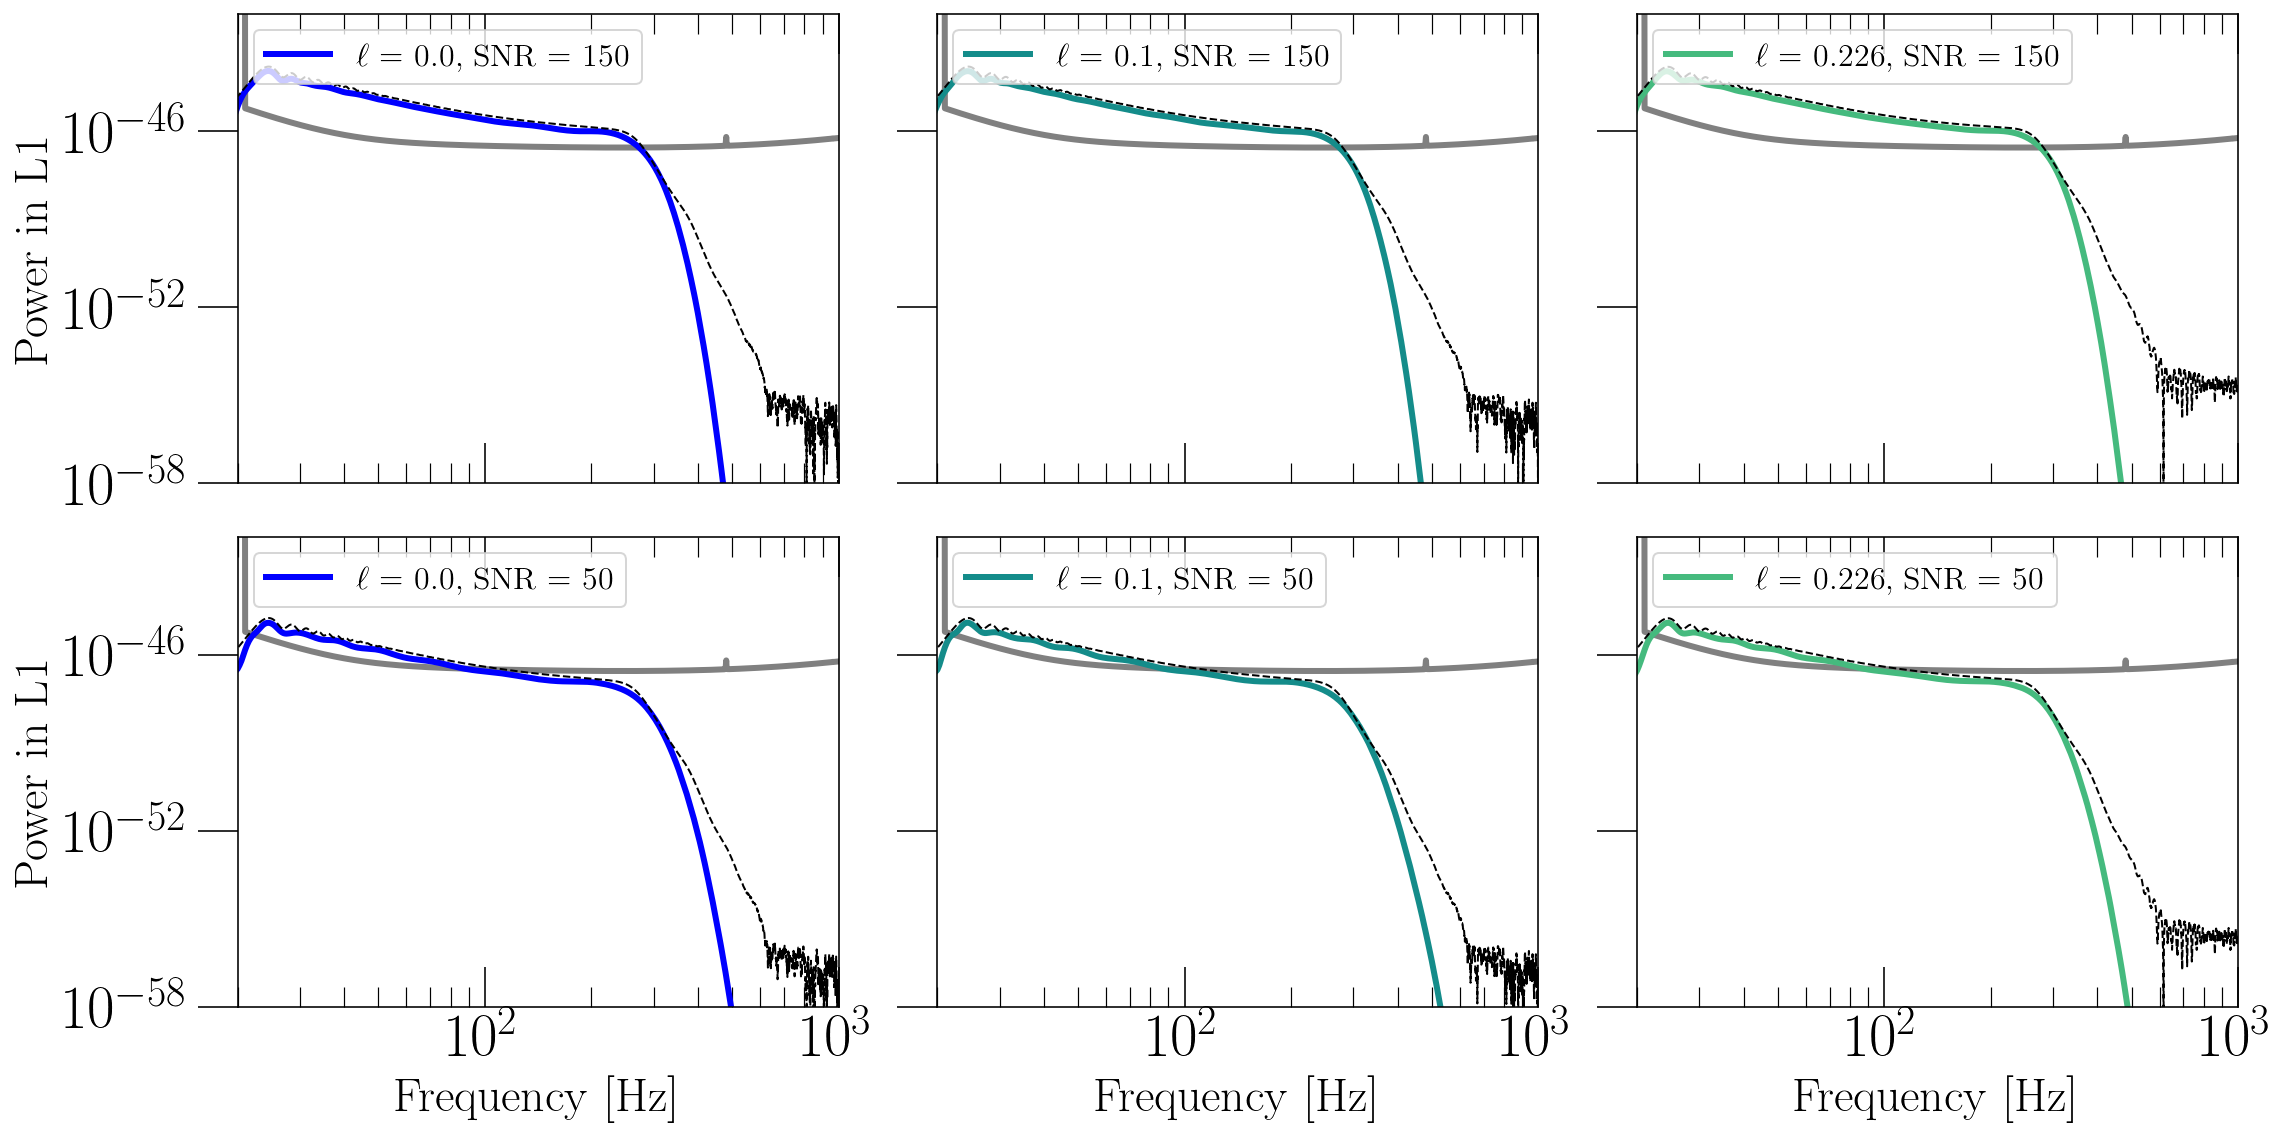

In [199]:
def PlotFrequencyData(ax, ell, SNR, color):
    
    label = r'$\ell$ = ' + str(ell) + ', SNR = ' + str(SNR)
    
    freq, psd = GetPSD(ell, SNR, "L1")
    freq, bw = GetBWFrequencyDomainWaveform(ell, SNR, "L1")
    freq, inj = GetInjectedFrequencyDomainWaveform(ell, SNR, "L1")
    
    ax.plot(freq, psd, color='grey')
    ax.plot(freq, np.abs(bw), label = label, color=color)
    ax.plot(freq, np.abs(inj), color='black', ls='--', lw=1.0) 
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(20, 1000)
    ax.set_ylim(1e-58, 1e-42)
    ax.legend(frameon=True, fontsize=16, loc='upper left')

fig, axarr = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

PlotFrequencyData(axarr[0][0], 0.0, 150, 'blue')
PlotFrequencyData(axarr[0][1], 0.1, 150, '#148c8a')
PlotFrequencyData(axarr[0][2], 0.226, 150, '#45ba7e')
PlotFrequencyData(axarr[1][0], 0.0, 50, 'blue')
PlotFrequencyData(axarr[1][1], 0.1, 50, '#148c8a')
PlotFrequencyData(axarr[1][2], 0.226, 50, '#45ba7e')

#plt.legend(frameon=False, fontsize=20)
#plt.ylabel('Power in L1')
for i in range(3):
    axarr[1][i].set_xlabel('Frequency [Hz]')
for i in range(2):
    axarr[i][0].set_ylabel('Power in L1')

plt.tight_layout()
plt.savefig('BayeswaveFreq.pdf')

plt.show()


## Compute overlaps

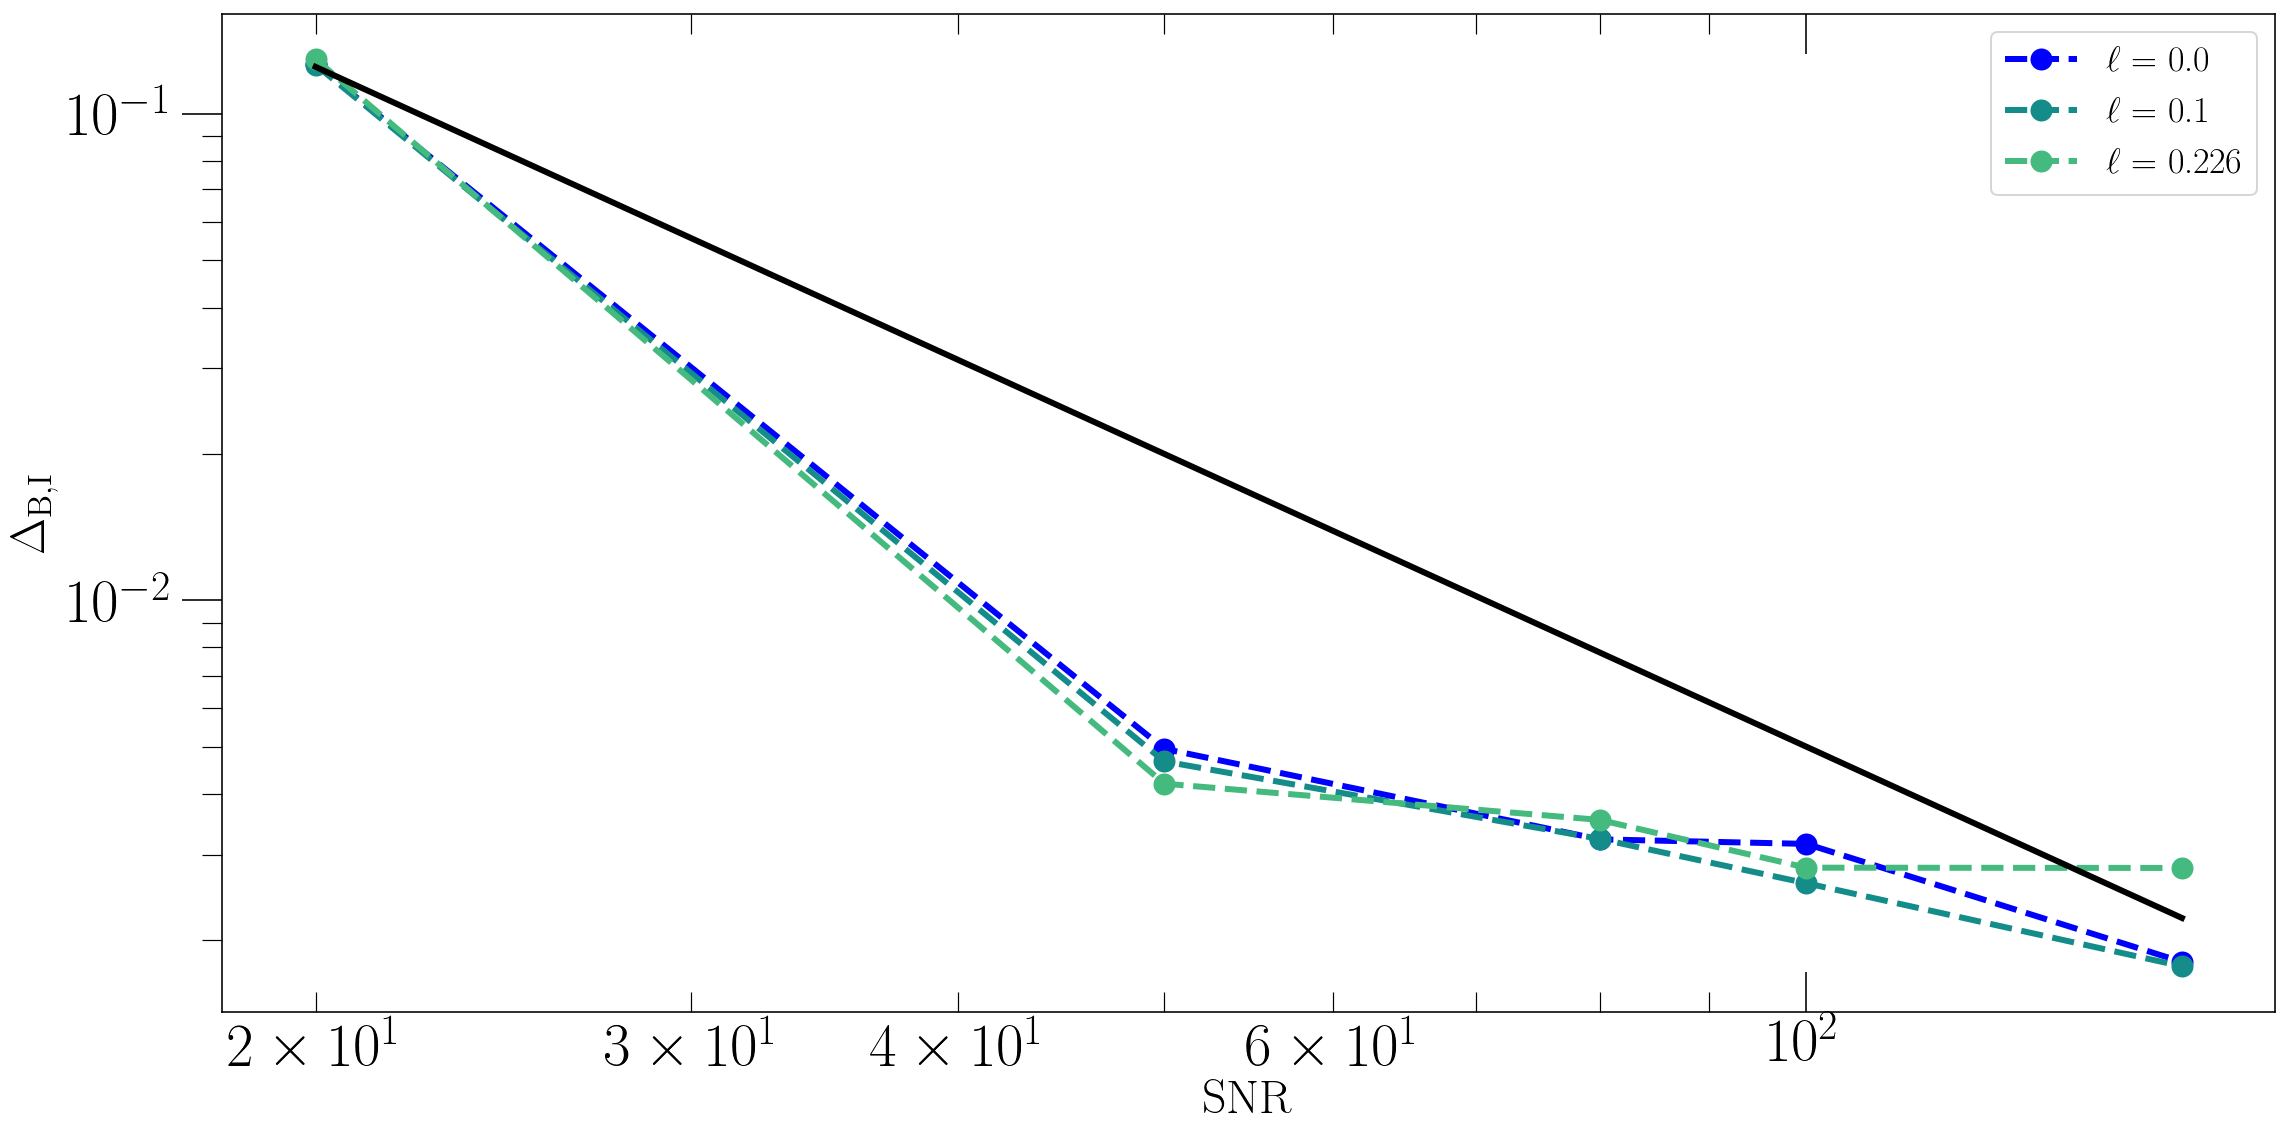

In [228]:

def InnerProduct(freq, hA, hB, PSD):

    """ Compute the inner product using the conventions of 
    https://arxiv.org/abs/2003.09456 Eq. 8"""
    
    ## Spacing in frequency
    df = freq[1] - freq[0]
    
    ## Terms inside the integral
    product = hA * np.conj(hB) / PSD 
    
    ## Compute the integral 
    total = 4.0 * np.real(np.sum(product)) * df
    return total
    
def Overlap(ell, SNR):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    total_bw_inj = 0.0
    total_bw_bw = 0.0
    total_inj_inj = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, SNR, detector)
        freq, bw = GetBWFrequencyDomainWaveform(ell, SNR, detector)
        freq, inj = GetInjectedFrequencyDomainWaveform(ell, SNR, detector)
        
        total_bw_inj = total_bw_inj + InnerProduct(freq, bw, inj, psd)
        total_bw_bw = total_bw_bw + InnerProduct(freq, bw, bw, psd)
        total_inj_inj = total_inj_inj + InnerProduct(freq, inj, inj, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_bw_inj / np.sqrt(total_bw_bw  * total_inj_inj)
    return overlap
    

plt.figure(figsize=(16, 8))
SNRs = [20, 50, 80, 100, 150]

ells = [0.0, 0.1, 0.226]
colors = ['blue', '#148c8a', '#45ba7e']
for ell, c in zip(ells, colors):
    deltas = [1.0 - Overlap(ell, snr) for snr in SNRs]
    plt.plot(SNRs, deltas, '--o', color=c, label=r'$\ell$ = ' + str(ell), markersize=10)
    
## Add in 1/SNR^2 curve 
snrs = np.linspace(SNRs[0], SNRs[-1], 100)
snr_curve = snrs**-2.0
plt.plot(snrs, snr_curve*50, color='black')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$\Delta_\mathrm{B,I}$')
plt.xlabel('SNR')
plt.tight_layout()
plt.savefig('Deltas.pdf')

plt.show()
    